# Imports

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
import xgboost
import time
from joblib import dump, load
import os

# Load the data

In [14]:
df = pd.read_csv('final_data.csv')

In [15]:
df.columns

Index(['minute', 'position_name', 'shot_body_part_name', 'shot_technique_name',
       'shot_type_name', 'shot_first_time', 'shot_one_on_one',
       'shot_aerial_won', 'shot_open_goal', 'shot_follows_dribble',
       'shot_redirect', 'x1', 'y1', 'number_of_players_opponents',
       'number_of_players_teammates', 'is_goal', 'angle', 'distance',
       'x_player_opponent_Goalkeeper', 'x_player_opponent_8',
       'x_player_opponent_1', 'x_player_opponent_2', 'x_player_opponent_3',
       'x_player_teammate_1', 'x_player_opponent_4', 'x_player_opponent_5',
       'x_player_opponent_6', 'x_player_teammate_2', 'x_player_opponent_9',
       'x_player_opponent_10', 'x_player_opponent_11', 'x_player_teammate_3',
       'x_player_teammate_4', 'x_player_teammate_5', 'x_player_teammate_6',
       'x_player_teammate_7', 'x_player_teammate_8', 'x_player_teammate_9',
       'x_player_teammate_10', 'y_player_opponent_Goalkeeper',
       'y_player_opponent_8', 'y_player_opponent_1', 'y_player_oppone

In [16]:
df.head()

,minute,position_name,shot_body_part_name,shot_technique_name,shot_type_name,shot_first_time,shot_one_on_one,shot_aerial_won,shot_open_goal,shot_follows_dribble,...,y_player_teammate_5,y_player_teammate_6,y_player_teammate_7,y_player_teammate_8,y_player_teammate_9,y_player_teammate_10,x_player_opponent_7,y_player_opponent_7,x_player_teammate_Goalkeeper,y_player_teammate_Goalkeeper
0,0,Right Center Forward,Right Foot,Normal,Open Play,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,Right Center Forward,Left Foot,Normal,Open Play,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,Center Midfield,Right Foot,Half Volley,Open Play,True,False,False,False,False,...,48.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,Left Center Midfield,Right Foot,Normal,Open Play,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Right Center Back,Left Foot,Normal,Open Play,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data preparation

In [17]:
# Change the type of categorical features to 'category' 
df[['position_name', 
    'shot_technique_name', 
    'shot_type_name', 
    'number_of_players_opponents', 
    'number_of_players_teammates', 
    'shot_body_part_name']] = df[['position_name', 
                                  'shot_technique_name', 
                                  'shot_type_name', 
                                  'number_of_players_opponents', 
                                  'number_of_players_teammates', 
                                  'shot_body_part_name']].astype('category')

In [18]:
# Splitting the dataset into features (X) and the target variable (y)
y = pd.DataFrame(df['is_goal'])
X = df.drop(['is_goal'], axis=1)

# Splitting the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create cross-validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [19]:
count_class_0, count_class_1 = y_train.value_counts()

# Display the count of shots attempted in the training set
print('Shots attempted in the training set:', count_class_0)

# Display the count of successful goals in the training set
print('Goals scored in the training set:', count_class_1)

Shots attempted in the training set: 27085
Goals scored in the training set: 3588


In [20]:
# Class imbalance in training data
scale_pos_weight = count_class_0 / count_class_1
print(f' Class imbalance in training data: {scale_pos_weight:.3f}')

 Class imbalance in training data: 7.549


# Training XGBoost model 

In [21]:
# Define the xgboost model
xgb_model = xgboost.XGBClassifier(enable_categorical=True, tree_method='hist', objective='binary:logistic')

In [22]:
# Defining the hyper-parameter grid for XG Boost
param_grid_xgb = {'learning_rate': [0.01, 0.001, 0.0001],
              'max_depth': [3, 5, 7, 8, 9],
              'n_estimators': [100, 150, 200, 250, 300],
              'scale_pos_weight': [1, scale_pos_weight]}

In [23]:
# Starting the timer
start_time = time.time()

# Perform grid search with cross-validation
grid_xg = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the best model on the entire training set
grid_xg.fit(X_train, y_train)

# Take the best parameters for xgboost model
best_xgb_model = grid_xg.best_estimator_

# Stopping the timer
stop_time = time.time()

# Training Time
xgb_training_time = stop_time - start_time

In [24]:
# Print the best parameters and training time
print("Best parameters: ", grid_xg.best_params_)
print (f"Model Training Time: {xgb_training_time:.3f} seconds")

Best parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 1}
Model Training Time: 912.022 seconds


# Model evaluation

## Training set

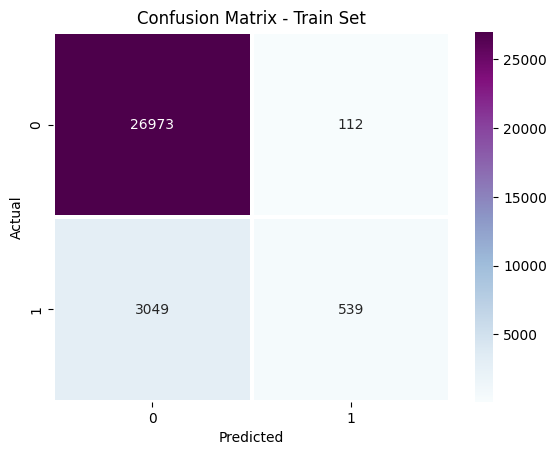

In [25]:
# Evaluate the model on training set
y_pred_train = best_xgb_model.predict(X_train)

# Confusion Matrix for Training Data
cm_train_xg = confusion_matrix(y_train, y_pred_train)
ax = sns.heatmap(cm_train_xg, annot=True, cmap='BuPu', fmt='g', linewidth=1.5)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Train Set')
plt.show()

## Test set

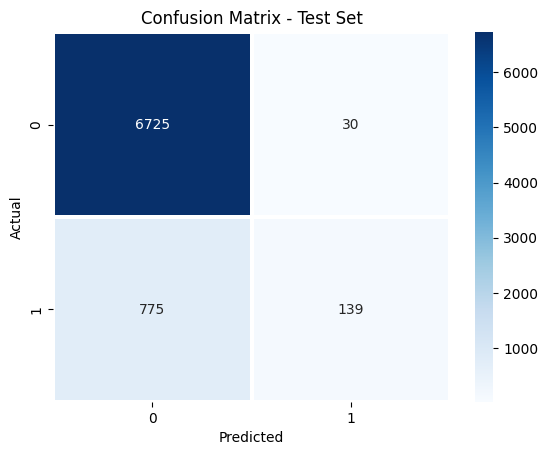

In [26]:
# Evaluate the model on test set
y_pred_test = best_xgb_model.predict(X_test)

# Confusion Matrix for Testig Data
cm_test_xgb = confusion_matrix(y_test, y_pred_test)
ax = sns.heatmap(cm_test_xgb, annot=True, cmap='Blues', fmt='g', linewidth=1.5)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Test Set')
plt.show()

In [27]:
# Number of goals in test set
print(f'The test dataset contains {len(y_test)} shots, with {y_test.sum()["is_goal"]} of them being goals.')

The test dataset contains 7669 shots, with 914 of them being goals.


## Feature importance

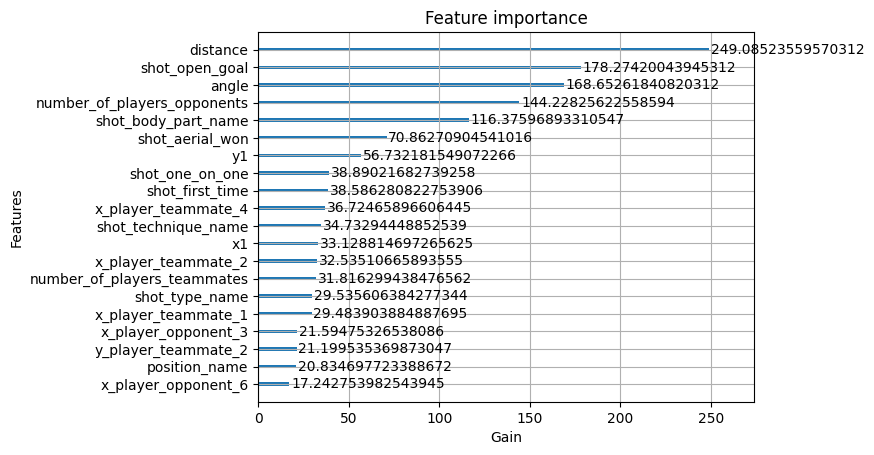

In [28]:
# Plot feature importance with Gain
xgboost.plot_importance(best_xgb_model, importance_type='gain', xlabel='Gain', max_num_features=20)
plt.show()

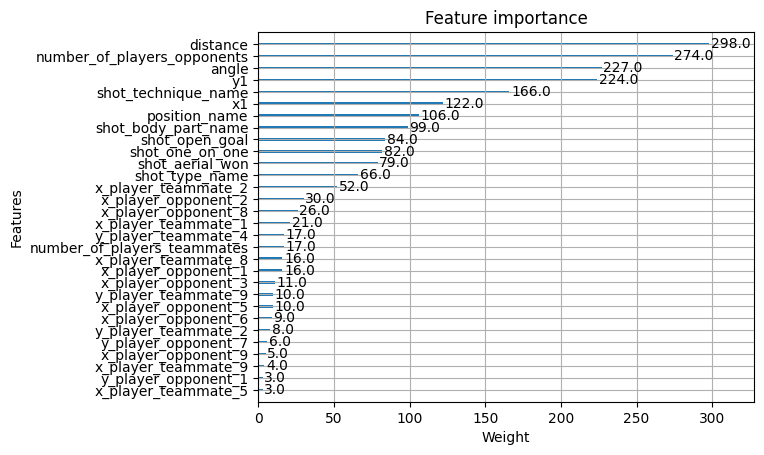

In [29]:
# Plot feature importance with Weight
xgboost.plot_importance(best_xgb_model, importance_type='weight', xlabel='Weight', max_num_features=30)
plt.show()

## Summary

In [30]:
# Calculating MAE, RMSE and R2 for training and test sets 
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
r2_train = r2_score(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
r2_test = r2_score(y_test, y_pred_test)

In [31]:
# Creating of dataframe of summary results
summary_df = pd.DataFrame({'Model Name':['XG Boost'],
                          'Training MAE': mae_train, 
                          'Training RMSE': rmse_train,
                          'Training R2':r2_train,
                          'Testing MAE': mae_test, 
                          'Testing RMSE': rmse_test,
                          'Testing R2':r2_test,
                          'Training Time (mins)': xgb_training_time/60})
summary_df.set_index('Model Name', inplace=True)

# Displaying summary of results
summary_df.style.format(precision =5).set_properties(**{'font-weight': 'bold',
            'border': '2.0px solid grey','color': 'white'})

,Training MAE,Training RMSE,Training R2,Testing MAE,Testing RMSE,Testing R2,Training Time (mins)
Model Name,,,,,,,
XG Boost,0.10305,0.32102,0.00230,0.10497,0.32399,0.00009,15.20037


# Keeping the xgboost model

In [32]:
# Save the model
dump(best_xgb_model, 'xgboost.joblib') 

# Load the model
model = load('xgboost.joblib')